# Optical Flow comparison

In this notebook we compare the optical flow estimated using the `pidrone_pkg` code with the new estimator based on the [OpenCV Farneback Flow algorithm](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af).

We have a rosbag recorded from the DD24 using the `pidrone_pkg` containing the sequence of compressed images recorded, the motion vectors provided by the `raspicam_node` package and the overall twist estimate generated by `optical_flow_node`. All additional topics are also recorded, in particular the `/pidrone/range` topic is used by `optical_flow_node` to scale the flow by the height of the drone.

Using the sequence of recorded images we can compute the motion vectors with the OpenCV Farneback Flow algorithm, a dense optical flow algorithm that provides motion vectors for each pixel in the image (or a binned copy of the image).

In [ ]:
from typing import List
import rosbag
import cv2
import numpy as np
from cv_bridge import CvBridge, CvBridgeError
import matplotlib.pyplot as plt

from cv2.typing import MatLike, MatShape

# Initialize CvBridge
bridge = CvBridge()

# Path to your rosbag file
rosbag_path = 'bags/optical_flow_pidrone_pkg/optical_flow_fisheye_cam_angled.bag'

# Set the topic name for compressed images and optical flow vectors
image_topic = '/raspicam_node/image/compressed'
flow_topic = '/pidrone/picamera/twist'
range_topic = '/pidrone/range'
motion_vectors_topic = '/raspicam_node/motion_vectors'

# Function to decompress and convert images from ROS format to OpenCV format
def decompress_image(msg):
    try:
        cv_image = bridge.compressed_imgmsg_to_cv2(msg, desired_encoding='bgr8')
        return cv_image
    except CvBridgeError as e:
        print(e)
        return None

# Open the rosbag
bag = rosbag.Bag(rosbag_path, 'r')

# Lists to store images and motion vectors
images : List[MatLike] = []
raw_linear_twists = []
range_list = []
raw_motion_vectors = []

# Loop through the bag and read the messages from the specified topics
for topic, msg, t in bag.read_messages(topics=[image_topic, flow_topic, range_topic, motion_vectors_topic]):
    if topic == image_topic:
        cv_image = decompress_image(msg)
        if cv_image is not None:
            images.append(cv_image)
    elif topic == flow_topic:
        # The motion vectors are already processed by the `optical_flow_node`
        raw_linear_twists.append(msg.twist.linear)
    elif topic == range_topic:
        range_list.append(msg.range)
    elif topic == motion_vectors_topic:
        raw_motion_vectors.append(msg)

bag.close()

In [ ]:
def compute_optical_flow(prev_img : MatLike, next_img : MatLike, binning_factor : int = 8):
    """Compute the optical flow between two grayscale images using Farneback's method."""
    prev_img_small = cv2.resize(prev_img, (prev_img.shape[1] // binning_factor, prev_img.shape[0] // binning_factor))
    next_img_small = cv2.resize(next_img, (next_img.shape[1] // binning_factor, next_img.shape[0] // binning_factor))
    
    # Compute optical flow on the smaller images
    flow_small = cv2.calcOpticalFlowFarneback(prev_img_small, next_img_small, None, 
                                              0.5, 3, 15, 3, 5, 1.2, 0)
    
    # Resize the flow back to the original image size
    flow = cv2.resize(flow_small, (prev_img.shape[1], prev_img.shape[0]))
    
    # Scale the flow values to match the original image size
    flow *= binning_factor
    
    return flow

def process_images_for_optical_flow(images):
    """Process a list of images to compute optical flow between consecutive frames."""
    computed_flows = []
    for i in range(1, len(images)):
        prev_img = cv2.cvtColor(images[i - 1], cv2.COLOR_BGR2GRAY)
        next_img = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
        flow = compute_optical_flow(prev_img, next_img)
        computed_flows.append(flow)
        # visualize_flow(flow, images[i])
    return computed_flows

farneback_flows = process_images_for_optical_flow(images)

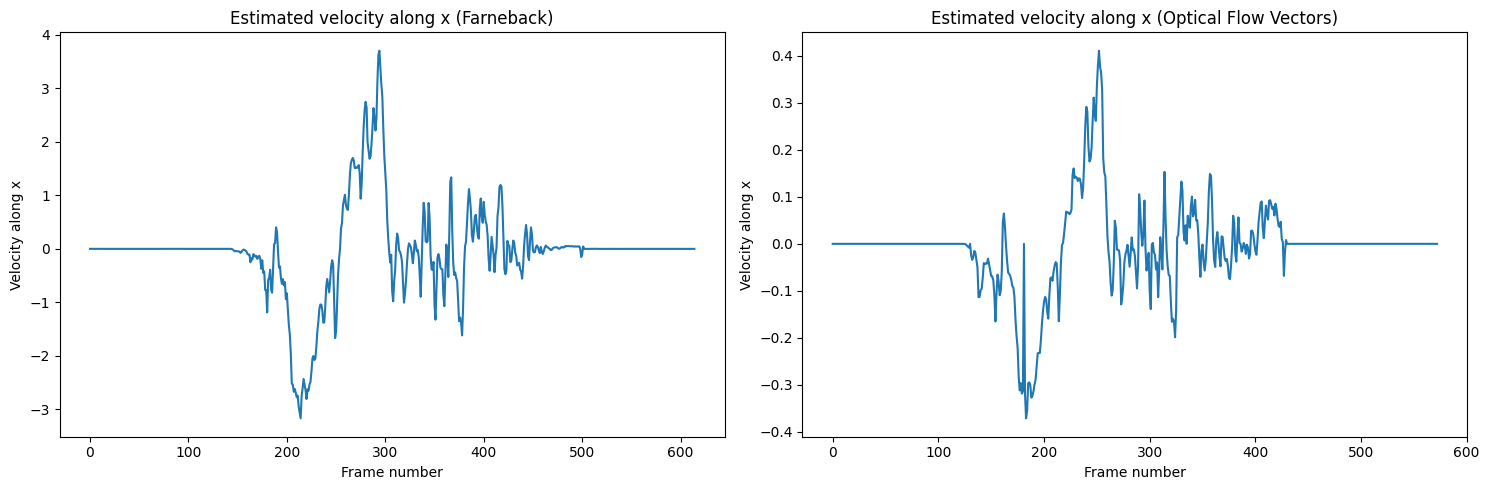

In [ ]:
# Estimate the velocity by summing all the optical flow vectors computed at each frame and plot it in a graph
# The optical flow vectors are in a list of numpy arrays with shape (image_width, image_height, 2) where the last dimension is the x and y components of the flow vector
# We can sum all the flow vectors to get the total flow vector at each pixel location

velocities = []

for flow in farneback_flows:
    vel = np.mean(flow, axis=(0, 1))
    velocities.append(vel)

def compute_scaling_factor():
        camera_wh = (640, 480)        
        max_flow = camera_wh[0] / 16.0 * camera_wh[1] / 16.0 * 2**7
        flow_scale = .165
        flow_coeff = 100 * flow_scale / max_flow # (multiply by 100 for cm to m conversion)
        
        return flow_coeff

flow_scaling_factor = compute_scaling_factor()

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the velocity along x in the first subplot
axs[0].plot([v[0]*h for v, h in zip(velocities, range_list)])
axs[0].set_xlabel('Frame number')
axs[0].set_ylabel('Velocity along x')
axs[0].set_title('Estimated velocity along x (Farneback)')

# Plot the velocity along x from the optical flow vectors in the second subplot
axs[1].plot([-v.x for v in raw_linear_twists])
axs[1].set_xlabel('Frame number')
axs[1].set_ylabel('Velocity along x')
axs[1].set_title('Estimated velocity along x (Optical Flow Vectors)')

# Show the plots
plt.tight_layout()
plt.show()


In [25]:
raw_motion_vectors[400]

header: 
  seq: 2252
  stamp: 
    secs: 1730982424
    nsecs: 519652366
  frame_id: "camera"
mbx: 40
mby: 30
x: [30, 58, -20, -2, -4, -4, 0, -2, -4, 14, -2, -52, 62, 2, 10, 6, 4, 0, 0, 0, 4, 4, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2

# v2 Stack

Now we compare this result with the v2 stack. The stack computes the motion vectors on a scaled down and rectified (check if the rectification is actually performed) image, then sends them through the ground projector to get them projected to a plane parallel to the bottom plate of the drone as to simulate a camera attached flat on this bottom plate. Then the overall velocity vector is estimated.

In [3]:
import rosbag

rosbag_path = 'bags/optical_flow_v2_comparison/vio_projected_stack.bag'
robot_name = 'virtualendeavour'


raw_vio_topic = f'/{robot_name}/optical_flow_node/debug/raw_odometry'
projected_vio_topic = f'/{robot_name}/optical_flow_node/visual_odometry'

bag = rosbag.Bag(rosbag_path, 'r')

raw_linear_twists = []
projected_twists = []

# Loop through the bag and read the messages from the specified topics
for topic, msg, t in bag.read_messages(topics=[raw_vio_topic, projected_vio_topic]):
    if topic == raw_vio_topic:
        raw_linear_twists.append(msg.twist.twist.linear)
    elif topic == projected_vio_topic:
        projected_twists.append(msg.twist.twist.linear)

bag.close()

len(raw_linear_twists), len(projected_twists)

(670, 670)

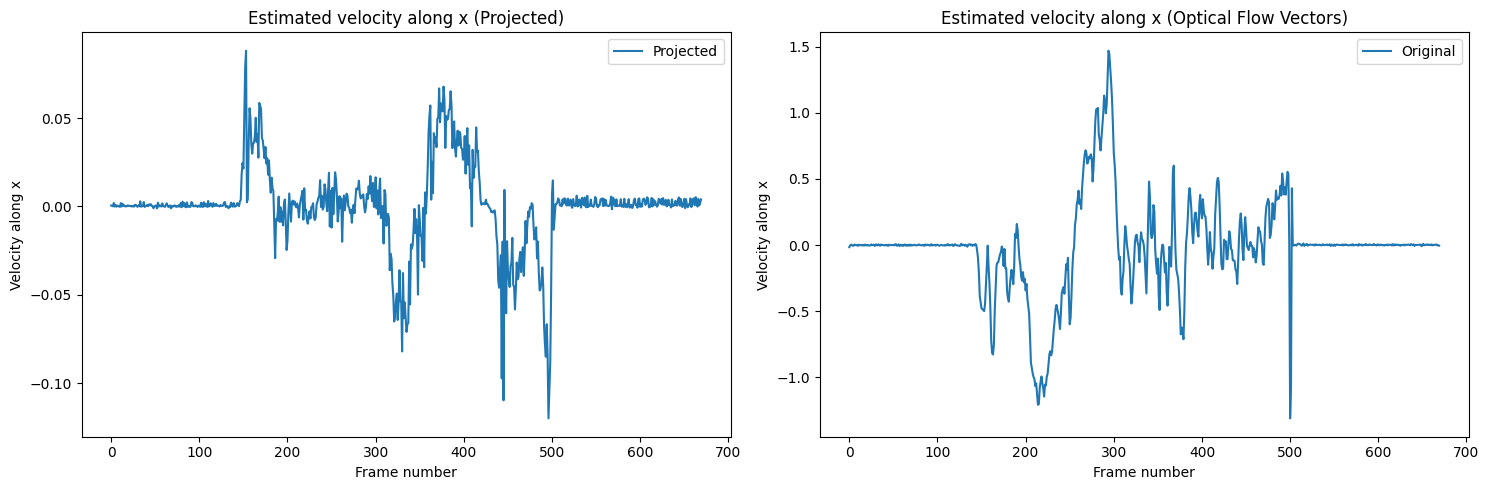

In [22]:
import matplotlib.pyplot as plt

def exponential_moving_average(data, alpha=0.1):
    smoothed_data = [data[0]]
    for i in range(1, len(data)):
        smoothed_data.append(alpha * data[i] + (1 - alpha) * smoothed_data[-1])
    return smoothed_data

alpha = 0.3

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the velocity along x in the first subplot
axs[0].plot([v.y for v in projected_twists], label='Projected')
# axs[0].plot(exponential_moving_average([v.y for v in projected_twists], alpha), label=f'Smoothed (alpha={alpha})')
axs[0].set_xlabel('Frame number')
axs[0].set_ylabel('Velocity along x')
axs[0].set_title('Estimated velocity along x (Projected)')
axs[0].legend()

# Plot the velocity along x from the optical flow vectors in the second subplot
axs[1].plot([v.x for v in raw_linear_twists], label='Original')
# axs[1].plot(exponential_moving_average([v.x for v in raw_linear_twists], alpha), label=f'Smoothed (alpha={alpha})')
axs[1].set_xlabel('Frame number')
axs[1].set_ylabel('Velocity along x')
axs[1].set_title('Estimated velocity along x (Optical Flow Vectors)')
axs[1].legend()

# Show the plots
plt.tight_layout()
plt.show()